In [1]:
### We will next go over the python implementation of U-net

In [86]:
### Import libraries
import math

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib inline
import glob

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Lambda, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from scipy.ndimage.measurements import label
import time
from sklearn.metrics import jaccard_similarity_score
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from keras.layers import *
from keras.utils import Sequence
from keras.backend import epsilon
import keras.backend as K
from keras.optimizers import Adam
from keras.regularizers import l2

import pandas as pd

BATCH_SIZE = 8

In [3]:
## Get path where files are to be stored

dir_label = ['images']

In [124]:
### Make data frame in Pandas
train_df = pd.read_csv('training.csv')
train_df['File_Path'] =  'images/'+train_df['image_name']
train_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'File_Path']
train_df = train_df[['File_Path','Frame','ymin','xmin','ymax','xmax']]
train_df.head()

File_Path  \
0      images/JPEG_20160706_121146_1000145715002.png   
1      images/JPEG_20161119_174038_1000690577600.png   
2  images/147444927651111470309333776-Roadster-Me...   
3            images/147772332675720161028_161611.png   
4            images/1473315333651DeeplearnS11638.png   

                                               Frame  ymin  xmin  ymax  xmax  
0             JPEG_20160706_121146_1000145715002.png   143   115   325   495  
1             JPEG_20161119_174038_1000690577600.png    61    23   409   457  
2  147444927651111470309333776-Roadster-Men-Casua...    13    37   470   601  
3                   147772332675720161028_161611.png   162    27   385   602  
4                   1473315333651DeeplearnS11638.png   174    60   325   586

In [126]:
train_df.tail()

File_Path  \
13995      images/JPEG_20161123_192639_1000159593348.png   
13996      images/JPEG_20160630_112055_1000866032892.png   
13997      images/JPEG_20161209_144221_1000965510278.png   
13998  images/1469616355586JPEG_20160625_121504_10003...   
13999      images/JPEG_20160711_125046_1000355681348.png   

                                                   Frame  ymin  xmin  ymax  \
13995             JPEG_20161123_192639_1000159593348.png    32    71   457   
13996             JPEG_20160630_112055_1000866032892.png   110    72   273   
13997             JPEG_20161209_144221_1000965510278.png    26     0   480   
13998  1469616355586JPEG_20160625_121504_100033222506...    31   254   449   
13999             JPEG_20160711_125046_1000355681348.png   101   212   454   

       xmax  
13995   383  
13996   577  
13997   485  
13998   375  
13999   437

In [125]:
### Make data frame in Pandas
test_df = pd.read_csv('validation.csv')
test_df['File_Path'] =  'images/'+test_df['image_name']
test_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'File_Path']
test_df = test_df[['File_Path','Frame','ymin','xmin','ymax','xmax']]
test_df.head()

File_Path  \
0      images/JPEG_20160624_135055_1000527160000.png   
1            images/147771890839520161028_141911.png   
2                   images/1474715198275DSC07675.png   
3      images/JPEG_20161117_112207_1000880661419.png   
4  images/147444941744811473248953580-Roadster-Me...   

                                               Frame  ymin  xmin  ymax  xmax  
0             JPEG_20160624_135055_1000527160000.png   165   132   325   606  
1                   147771890839520161028_141911.png    52   123   452   544  
2                          1474715198275DSC07675.png    32   311   459   458  
3             JPEG_20161117_112207_1000880661419.png     5    13   459   640  
4  147444941744811473248953580-Roadster-Men-Navy-...    16    34   471   603

In [7]:
trans_range = 0

In [8]:
### Augmentation functions 

def augment_brightness_camera_images(image):
    
    ### Augment brightness 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,bb_boxes_f,trans_range):
    # Translation augmentation
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin']+tr_x).clip(0,640)
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax']+tr_x).clip(0,640)
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin']+tr_y).clip(0,480)
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax']+tr_y).clip(0,480)
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,bb_boxes_f


def stretch_image(img,bb_boxes_f,scale_range):
    # Stretching augmentation 
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = ((bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['xmax'] = ((bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['ymin'] = ((bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    bb_boxes_f['ymax'] = ((bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    
    return img,bb_boxes_f



def get_image_name(df,ind,size=(640,480),augmentation = False,trans_range = 20,scale_range=20):
    ### Get image by name
    
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    #print(name_str)
    #print(file_name)
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img,bb_boxes = trans_image(img,bb_boxes,trans_range)
        img,bb_boxes = stretch_image(img,bb_boxes,scale_range)
        img = augment_brightness_camera_images(img)
        
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    #bb_boxes = bb_boxes[bb_boxes['Area']>400]
        
    
    return name_str,img,bb_boxes


def get_mask_seg(img,bb_boxes_f, size=(640,480)):
    
    #### Get mask
    for i in range(len(bb_boxes_f)):
#         img = cv2.imread(img)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        cv2.equalizeHist(gray)

        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        fg = cv2.erode(thresh,None,iterations = 2)
        bgt = cv2.dilate(thresh,None,iterations = 3)
        ret,bg = cv2.threshold(bgt,1,128,1)
        marker = cv2.add(fg,bg)

        marker32 = np.int32(marker)
        cv2.watershed(img,marker32)
        m = cv2.convertScaleAbs(marker32)
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        bb_box_i = np.array(bb_box_i, dtype='int')
        ret,thresh = cv2.threshold(m,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(150,150)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(150,150)))

        res = cv2.bitwise_and(img,img,mask = thresh)    

        threshres = np.zeros( (len(img), len(img[0])) )
        threshres[ bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2] ] = thresh[ bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2] ]
        img_mask = np.reshape(threshres,(np.shape(threshres)[0],np.shape(threshres)[1],1))

#     img_mask = np.zeros_like(img[:,:,0])
#     for i in range(len(bb_boxes_f)):
#         #plot_bbox(bb_boxes,i,'g')
#         bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
#                 bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
#         bb_box_i = np.array(bb_box_i, dtype='int')
#         img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]] = 1.
#         img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

In [9]:
def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();
    
def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
    
def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
        
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')
#     plt.axis('off');


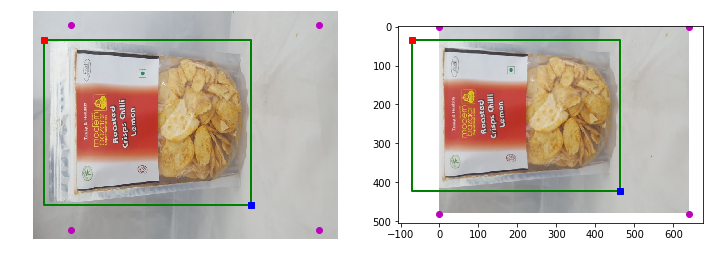

In [10]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

# plt.axis('off');


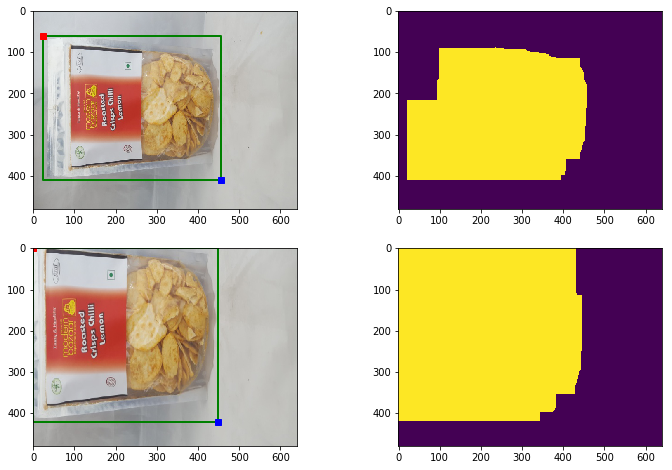

In [11]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
# plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
# plt.axis('off')

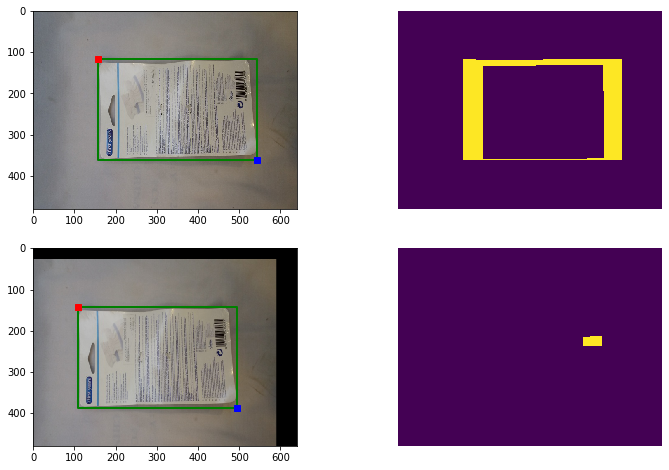

In [12]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

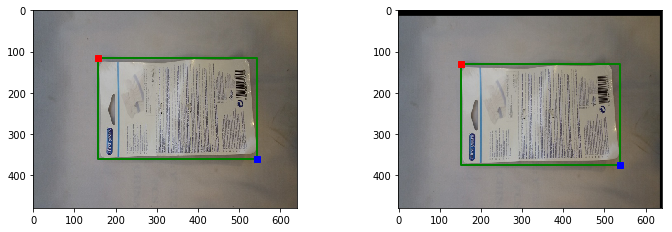

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)


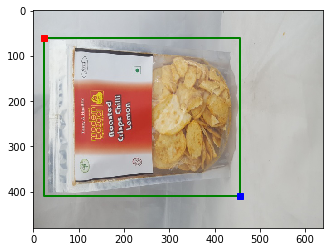

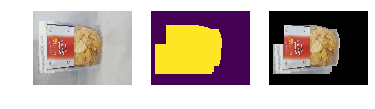

In [14]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

In [140]:
class DataGenerator(Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, aug = False, img_rows = 480, img_cols = 640,
                trans_range = 0, scale_range = 0):
            
        self.df = df
        self.aug = aug
        self.batch_size = batch_size
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.trans_range = trans_range
        self.scale_range = scale_range

    def __len__(self):
        return math.floor(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_images = np.zeros((self.batch_size, img_rows, img_cols, 3))
        batch_masks = np.zeros((self.batch_size, img_rows, img_cols, 1))
        for batch_id, i_batch in enumerate(range(self.batch_size*idx, self.batch_size*(idx+1))):
            name_str,img,bb_boxes = get_image_name(self.df,i_batch,
                                                       size=(self.img_cols, self.img_rows),
                                                       augmentation=self.aug,
                                                       trans_range=self.trans_range,
                                                       scale_range=self.scale_range)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[batch_id] = img
            batch_masks[batch_id] = img_mask/255
        return batch_images, batch_masks

In [112]:
traingen = DataGenerator(train_df)

In [113]:
imgs, masks = (traingen).__getitem__(2)

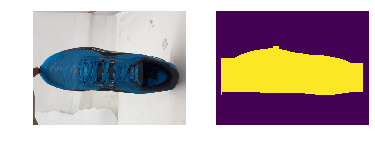

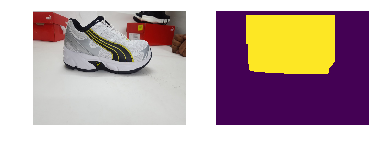

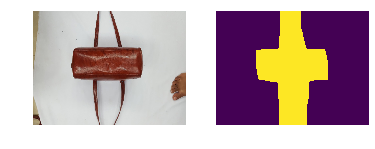

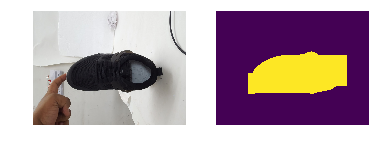

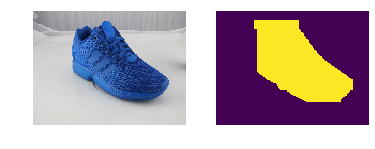

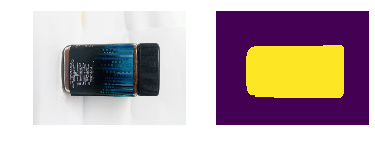

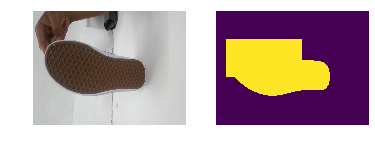

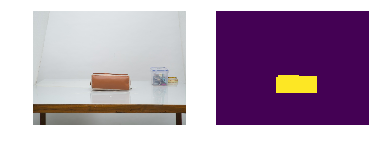

In [114]:
for i in range(8):
    im = np.array(imgs[i],dtype=np.uint8)
    im_mask = np.array(masks[i],dtype=np.uint8)
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.show()

In [62]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 8):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
#             i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(train_df,i_batch,
                                                   size=(img_cols, img_rows),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask/255
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-200)
            name_str,img,bb_boxes = get_image_name(test_df,i_batch,
                                                   size=(img_cols, img_rows),
                                                   augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask/255
        yield batch_images, batch_masks

In [31]:
##### Image size, 
img_rows = 480
img_cols = 640

In [68]:
##### Testing the generator
training_gen = generate_train_batch(train_df,32)

In [73]:
batch_img,batch_mask = next(training_gen)
# batch_mask

In [74]:
batch_mask[0].max()

1.0

In [75]:
batch_img[0].shape

(480, 640, 3)

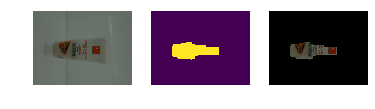

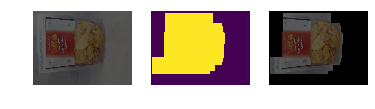

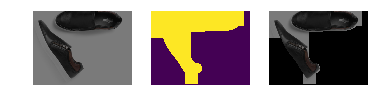

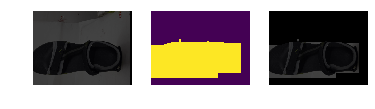

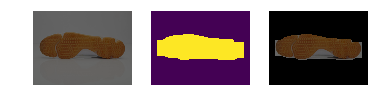

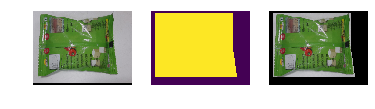

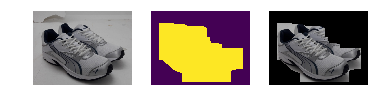

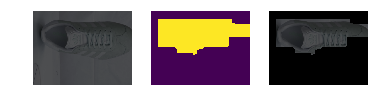

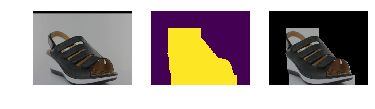

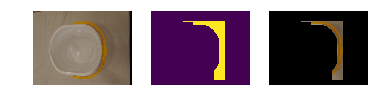

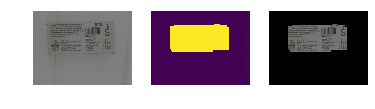

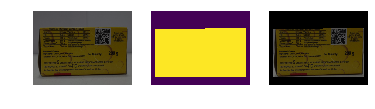

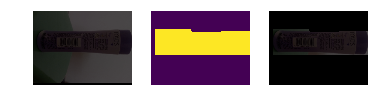

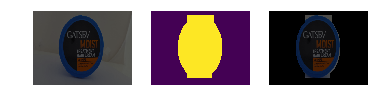

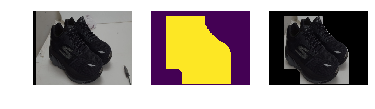

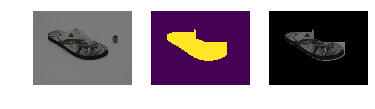

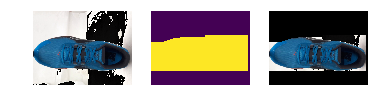

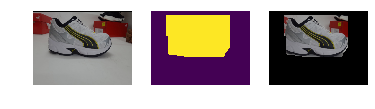

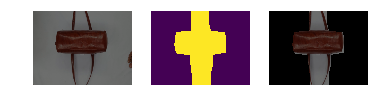

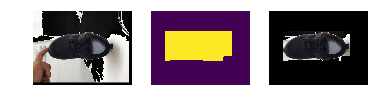

In [76]:
### Plotting generator output
for i in range(20):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.axis('off')
    plt.show()

In [63]:
##### Testing the generator
testing_gen = generate_test_batch(train_df,32)


In [66]:

batch_img,batch_mask = next(testing_gen)

In [41]:
len(train_df)
len(test_df)

1400

In [115]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection) / (K.sum(y_true_f + y_pred_f))


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [116]:
def dice_coefficient(y_true, y_pred):
    num = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    den = tf.reduce_sum(y_true + y_pred, axis=-1)
    
    return num / (den + epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + epsilon())

In [117]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [118]:
def get_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model    

In [141]:
### Generator 

training_gen = DataGenerator(train_df, batch_size=4, aug=True, img_rows = 480, img_cols = 640,
                trans_range = 50, scale_range = 50)
smooth = 1.
model = get_unet()
model.compile(optimizer=Adam(lr=1e-4, decay=2e-6), 
              loss=loss, metrics=[IOU_calc])

In [142]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 480, 640, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 480, 640, 64) 36928       conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 240, 320, 64) 0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 

In [143]:
### Using previously trained data. Set load_pretrained = False, increase epochs and train for full training.
load_pretrained = True

# if load_pretrained == True:
#     model.load_weights("uNet_big-0.85.h5")

checkpoint = ModelCheckpoint("uNet_new-{val_IOU_calc:.2f}.h5", monitor="val_IOU_calc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)

reduce_lr = ReduceLROnPlateau(monitor="val_IOU_calc", factor=0.2, patience=3, min_lr=1e-7, verbose=1, mode="max")

In [146]:
history = model.fit_generator(training_gen,
                              epochs=200,
                               validation_data = DataGenerator(test_df,16),
                               callbacks=[checkpoint]
                             )
                              

Epoch 1/200
3500/3500 [==============================] - 1271s 363ms/step - loss: 10.9596 - IOU_calc: 0.8426 - val_loss: 11.9343 - val_IOU_calc: 0.8329

Epoch 00001: val_IOU_calc did not improve from 0.83847
Epoch 2/200
 104/3500 [..............................] - ETA: 20:51 - loss: 11.0288 - IOU_calc: 0.8475

KeyboardInterrupt: 

In [ ]:
### Save model for use in detection pipeline

# model.save('model_save.h5')

In [ ]:
# ### Plot model using Keras 

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
### Save weights 
model.save_weights("model_weights.h5", overwrite=True)

In [30]:
### Testing generator

testing_gen = generate_test_batch(test_df,20)


In [31]:
np.shape(im)

(480, 640, 3)

In [32]:
import time

start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start

9.212284088134766

In [107]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, mask_pred):
    # Iterate through all detected cars
    arr = np.where(mask_pred[:,:,0]>240)[0]
    try:
        ymin = (np.min(arr[np.nonzero(arr)]))
    except ValueError:
        ymin = 0
    try:
        ymax = (np.max(arr[np.nonzero(arr)]))
    except ValueError:
        ymax = 0
    arr = np.where(mask_pred[:,:,0]>240)[1]
    try:
        xmin = (np.min(arr[np.nonzero(arr)]))
    except:
        xmin = 0
    try:
        xmax = (np.max(arr[np.nonzero(arr)]))
    except:
        xmax = 0
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,255), 3)
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    draw_img = draw_labeled_bboxes(img, im_pred)
    return draw_img

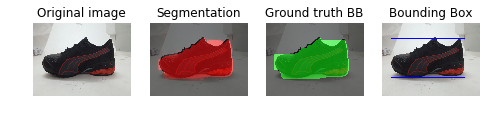

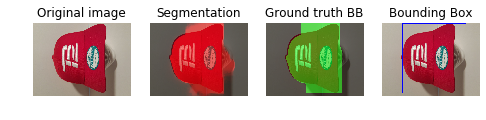

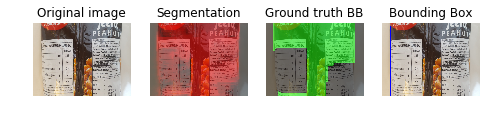

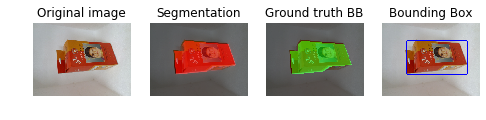

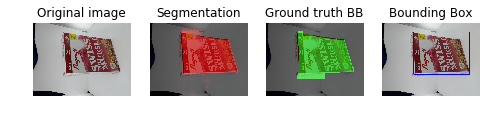

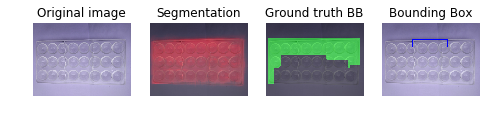

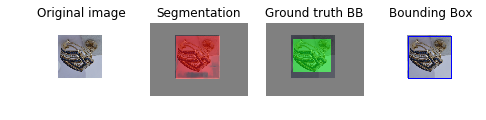

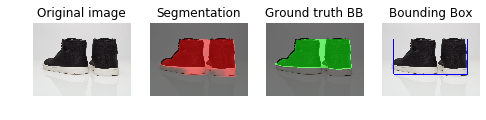

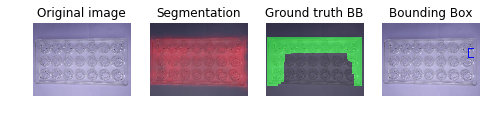

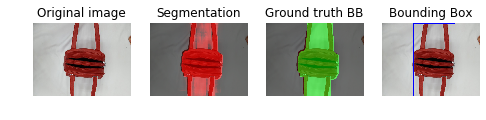

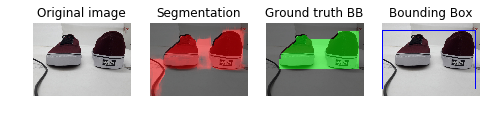

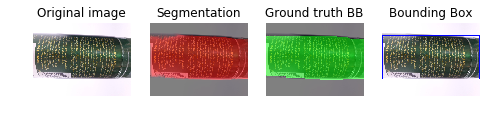

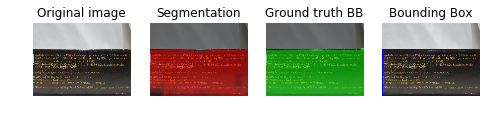

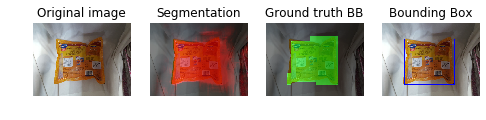

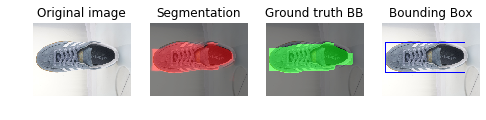

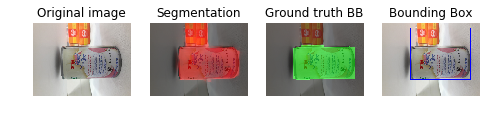

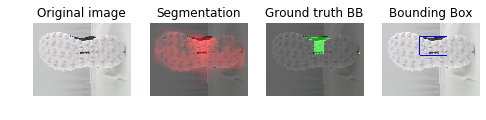

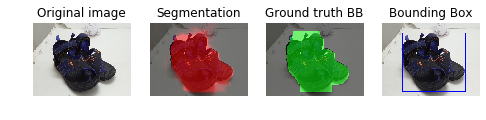

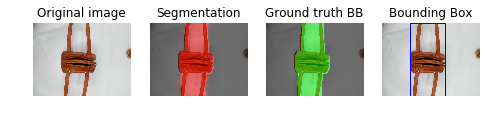

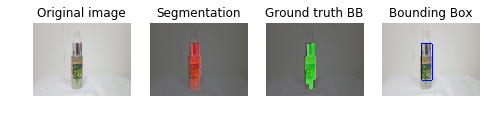

In [101]:
### Test on last frames of data

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

for i in range(len(pred_all)):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    draw_img = get_BB_new_img(im)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmentation')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');
    plt.show()


In [102]:
### Test on new image

test_img = 'images/147771890839520161028_141911.png'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

draw_img = get_BB_new_img(im)


Text(0.5, 1.0, 'Bounding Box')

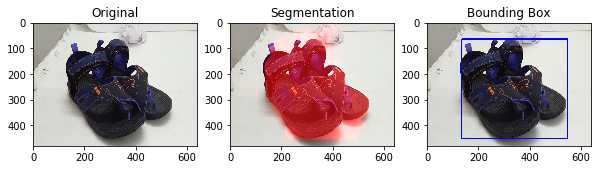

In [103]:
# test_img = 'test_images/test1.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = test_new_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
im_mask = np.array(255*batch_mask[0],dtype=np.uint8)
rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]


img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)

#heatmap = im_pred[:,:,0]

#labels = label(heatmap)
# Draw bounding boxes on a copy of the image
#draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
#img_pred = im
#im_pred[:,:,]

draw_img = get_BB_new_img(im)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
# plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentation')
# plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
# plt.axis('off');




In [200]:
#### EXTRA STUFF THAT I DIDNT USE. 

[[248]]


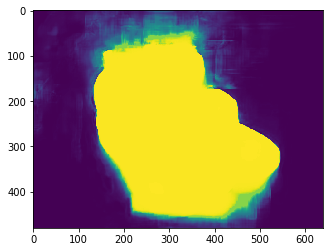

In [201]:
plt.imshow(im_pred[:,:,0])

print(im_pred[450:451,380:381,0])

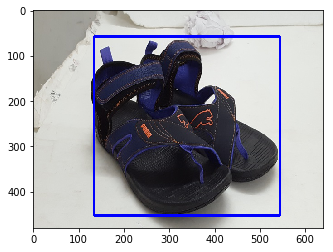

In [202]:


draw_img = draw_labeled_bboxes(im, im_pred)
# Display the image
plt.imshow(draw_img)
# plt.axis('off');

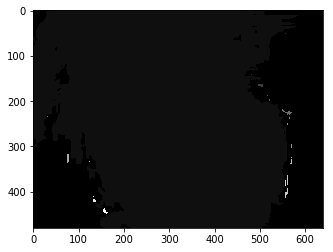

In [193]:
plt.imshow(labels[0],cmap='gray')

In [194]:
np.unique(labels[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int32)

In [195]:
car_label = 1

blob_non0 = (car_label == labels[0])

img_0 = np.copy(heatmap)*0
img_0[blob_non0] = 255

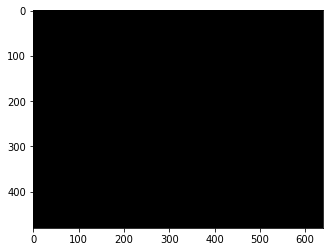

In [196]:
plt.imshow(blob_non0)
img_cny = cv2.Canny(img_0,128,255)
plt.imshow(img_cny,cmap='gray')

In [139]:
def custom_batch(data, index, batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            name_str,img,bb_boxes = get_image_name(test_df,index,
                                                   size=(img_cols, img_rows),
                                                   augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask/255
            index+=1
        yield batch_images, batch_masks

In [140]:
index = 0

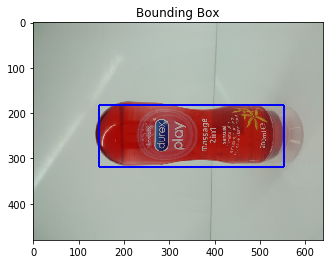

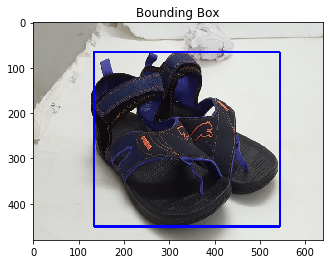

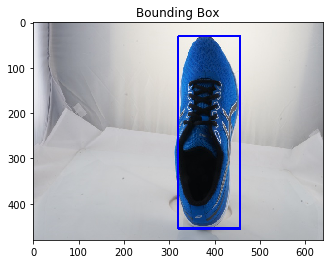

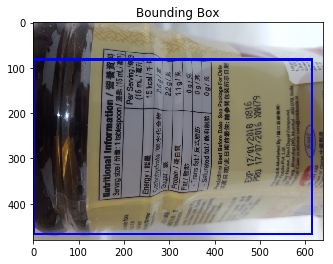

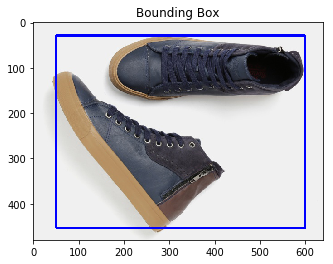

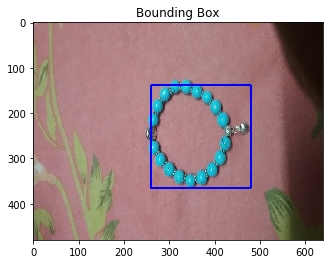

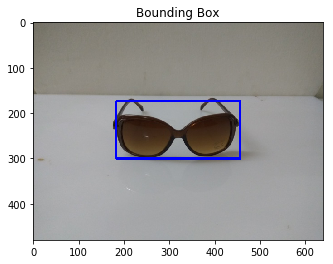

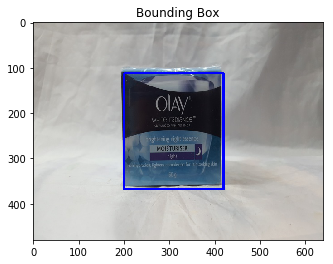

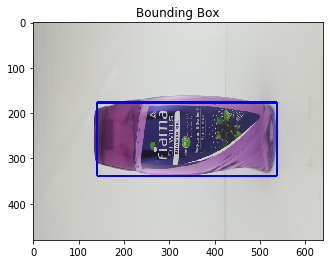

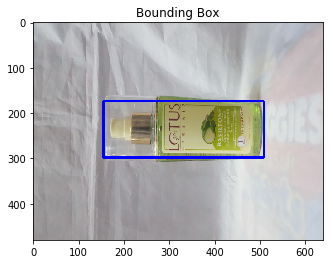

0


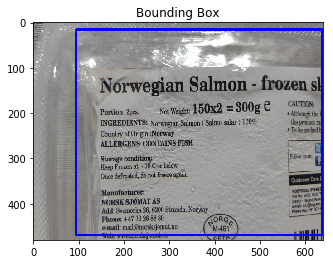

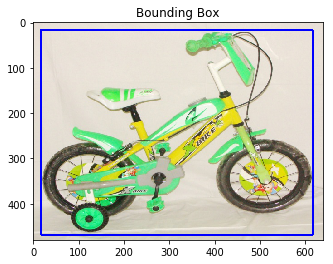

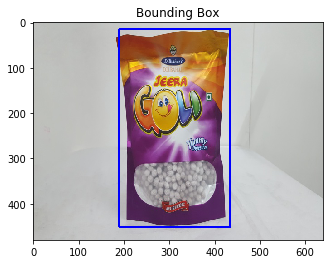

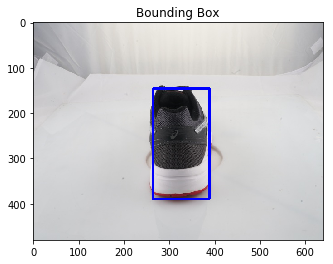

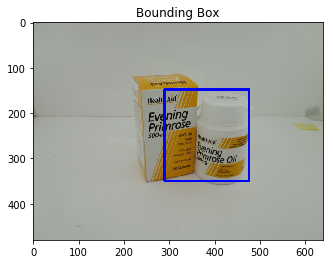

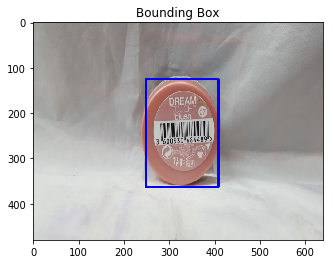

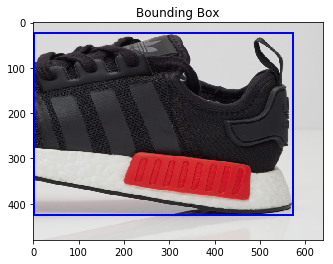

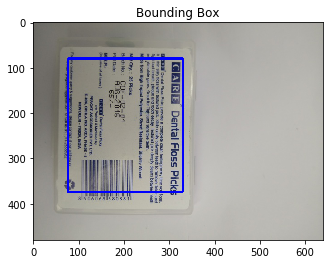

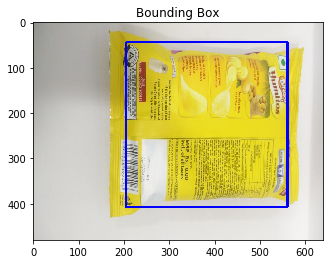

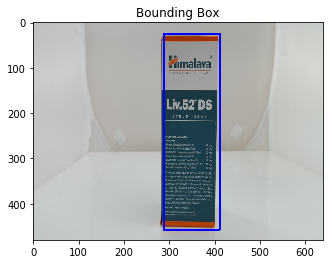

10


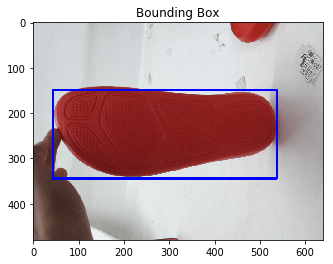

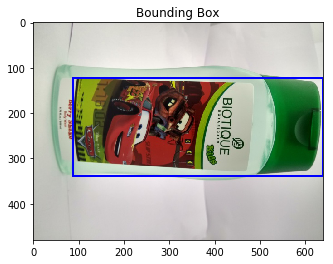

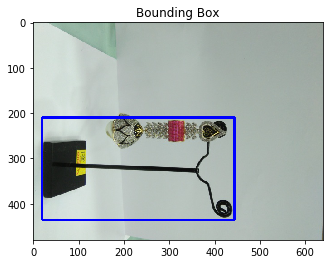

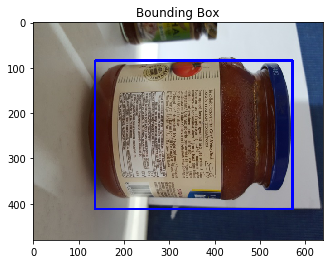

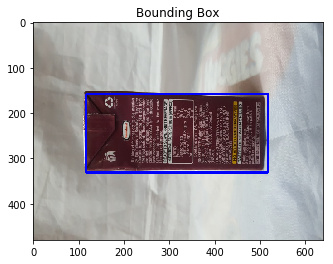

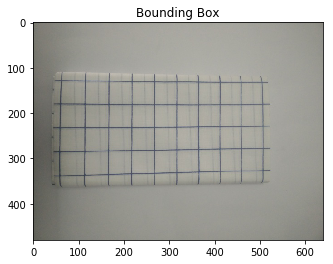

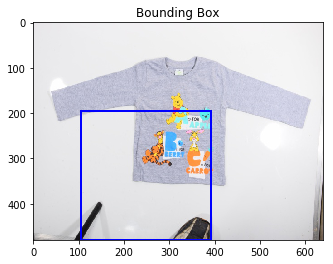

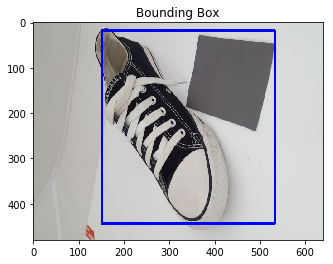

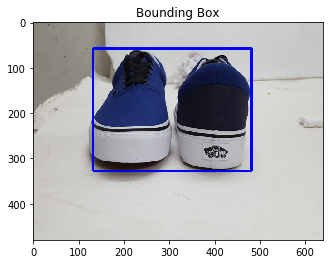

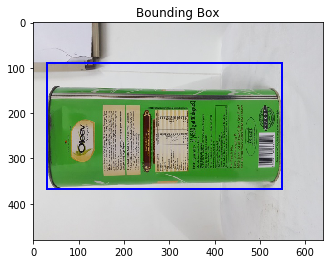

20


In [141]:
while index<len(testing_df):
    custom_gen = custom_batch(testing_df, index, batch_size=10)
    batch_img,batch_mask = next(custom_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)

    for i in range(len(pred_all)):

        im = np.array(batch_img[i],dtype=np.uint8)

        draw_img = get_BB_new_img(im)


        plt.imshow(draw_img)
        plt.title('Bounding Box')
        plt.show()
    print(index)
    index+=10
    if index>=10:
        break

In [122]:
testing_df = pd.read_csv('test.csv')
testing_df['Label'] = "test"
testing_df['File_Path'] =  'images/'+testing_df['image_name']
testing_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'Label', 'File_Path']
testing_df = testing_df[['File_Path','Frame','Label','ymin','xmin','ymax','xmax']]
testing_df.head()

File_Path  \
0               images/1474723840903DSC08089.png   
1        images/1473231475010DeeplearnS11276.png   
2  images/JPEG_20161205_135307_1000155917326.png   
3  images/JPEG_20160711_123440_1000518778437.png   
4   images/JPEG_20160803_115329_100034020722.png   

                                    Frame Label  ymin  xmin  ymax  xmax  
0               1474723840903DSC08089.png  test   NaN   NaN   NaN   NaN  
1        1473231475010DeeplearnS11276.png  test   NaN   NaN   NaN   NaN  
2  JPEG_20161205_135307_1000155917326.png  test   NaN   NaN   NaN   NaN  
3  JPEG_20160711_123440_1000518778437.png  test   NaN   NaN   NaN   NaN  
4   JPEG_20160803_115329_100034020722.png  test   NaN   NaN   NaN   NaN

In [126]:
final_df = pd.read_csv('test.csv')
final_df.head()

image_name  x1  x2  y1  y2
0               1474723840903DSC08089.png NaN NaN NaN NaN
1        1473231475010DeeplearnS11276.png NaN NaN NaN NaN
2  JPEG_20161205_135307_1000155917326.png NaN NaN NaN NaN
3  JPEG_20160711_123440_1000518778437.png NaN NaN NaN NaN
4   JPEG_20160803_115329_100034020722.png NaN NaN NaN NaN

In [127]:
def get_labeled_bboxes(mask_pred):
    # Iterate through all detected cars
    arr = np.where(mask_pred[:,:,0]>240)[0]
    try:
        ymin = (np.min(arr[np.nonzero(arr)]))
    except ValueError:
        ymin = 0
    try:
        ymax = (np.max(arr[np.nonzero(arr)]))
    except ValueError:
        ymax = 0
    arr = np.where(mask_pred[:,:,0]>240)[1]
    try:
        xmin = (np.min(arr[np.nonzero(arr)]))
    except:
        xmin = 0
    try:
        xmax = (np.max(arr[np.nonzero(arr)]))
    except:
        xmax = 0
    return (xmin,xmax,ymin,ymax)

In [128]:
def bboxes(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    bboxes = get_labeled_bboxes(im_pred)
    return bboxes

In [131]:
pd.options.mode.chained_assignment = None

In [135]:
for index,row in testing_df.iterrows():
    img = row['File_Path']
    im = cv2.imread(img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    bbox = bboxes(im)
    final_df['x1'][index] = bbox[0]
    final_df['x2'][index] = bbox[1]
    final_df['y1'][index] = bbox[2]
    final_df['y2'][index] = bbox[3]
    
final_df.head()

image_name     x1     x2     y1     y2
0               1474723840903DSC08089.png  244.0  441.0   96.0  405.0
1        1473231475010DeeplearnS11276.png   89.0  569.0  153.0  347.0
2  JPEG_20161205_135307_1000155917326.png  157.0  492.0   56.0  435.0
3  JPEG_20160711_123440_1000518778437.png  262.0  430.0  130.0  402.0
4   JPEG_20160803_115329_100034020722.png  152.0  496.0   46.0  429.0

In [136]:
final_df.to_csv('prediction_seg.csv', index=False)

In [137]:
ensemble_df = pd.read_csv('prediction_deci-0.925-average.csv')
ensemble_df.head()

image_name          x1          x2          y1  \
0               1474723840903DSC08089.png  232.040662  441.779713   87.920054   
1        1473231475010DeeplearnS11276.png   75.167886  567.913672  138.867147   
2  JPEG_20161205_135307_1000155917326.png  146.515890  494.650160   53.912044   
3  JPEG_20160711_123440_1000518778437.png  211.963335  465.495342   92.208279   
4   JPEG_20160803_115329_100034020722.png  138.245508  496.524932   45.368491   

           y2  
0  405.667681  
1  351.249280  
2  433.060859  
3  413.629267  
4  428.499024

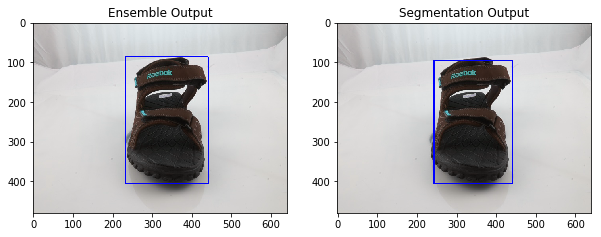

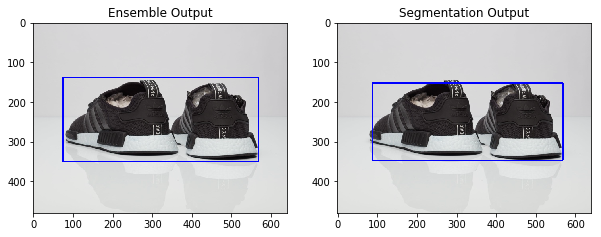

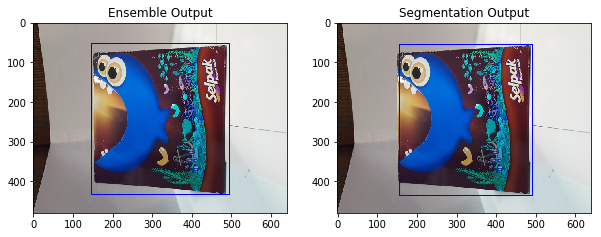

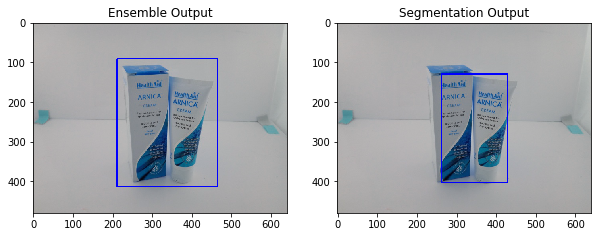

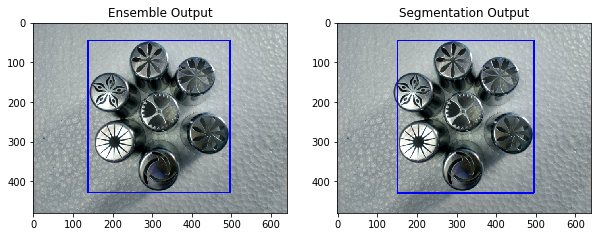

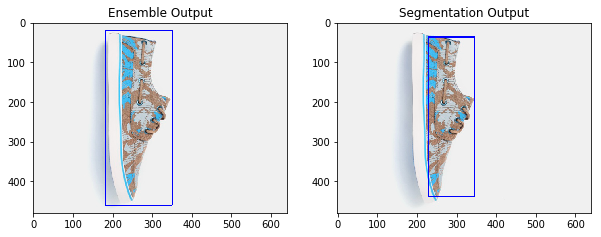

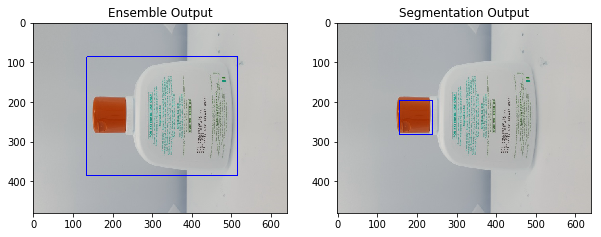

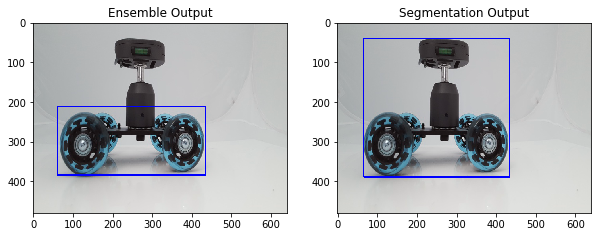

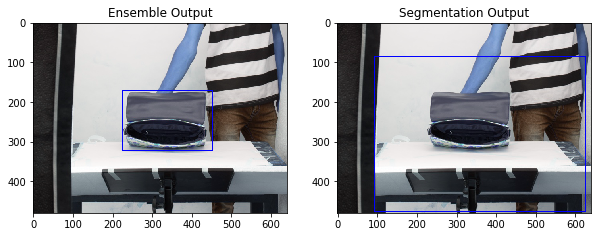

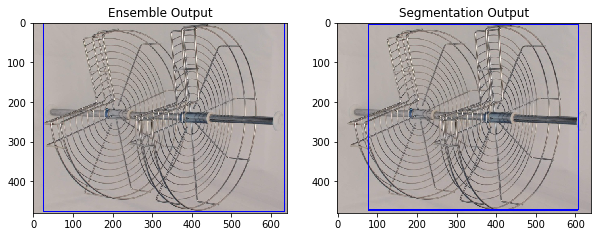

In [146]:
for i in range(10):
    tr_row = ensemble_df.loc[ i ]
    seg_row = final_df.loc[ i ]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    img = cv2.imread('images/' + tr_row['image_name'])
    cv2.rectangle(img, (int(tr_row['x1']), int(tr_row['y1'])),
                  (int(tr_row['x2']), int(tr_row['y2'])), (0,0,255), 2)
    plt.imshow(img)
    plt.title('Ensemble Output')
    plt.subplot(1,2,2)
    img_seg = cv2.imread('images/' + seg_row['image_name'])
    cv2.rectangle(img_seg, (int(seg_row['x1']), int(seg_row['y1'])),
                  (int(seg_row['x2']), int(seg_row['y2'])), (0,0,255), 2)
    plt.imshow(img_seg)
    plt.title('Segmentation Output')
    plt.show()

In [160]:
training_df = pd.read_csv('training.csv')
training_df.head()

image_name   x1   x2   y1   y2
0             JPEG_20160706_121146_1000145715002.png  115  495  143  325
1             JPEG_20161119_174038_1000690577600.png   23  457   61  409
2  147444927651111470309333776-Roadster-Men-Casua...   37  601   13  470
3                   147772332675720161028_161611.png   27  602  162  385
4                   1473315333651DeeplearnS11638.png   60  586  174  325

In [161]:
for index,row in train_df.iterrows():
    img = row['File_Path']
    im = cv2.imread(img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    bbox = bboxes(im)
    training_df['x1'][index] = bbox[0]
    training_df['x2'][index] = bbox[1]
    training_df['y1'][index] = bbox[2]
    training_df['y2'][index] = bbox[3]
    
training_df.head()

image_name   x1   x2   y1   y2
0             JPEG_20160706_121146_1000145715002.png  212  441  185  264
1             JPEG_20161119_174038_1000690577600.png   95  436   90  379
2  147444927651111470309333776-Roadster-Men-Casua...   82  581   21  436
3                   147772332675720161028_161611.png   33  597  175  377
4                   1473315333651DeeplearnS11638.png   64  585  187  325

In [162]:
training_df.to_csv('train3.csv', index=False)

In [150]:
valid_df = pd.read_csv('validation.csv')
valid_df.head()

image_name   x1   x2   y1   y2
0             JPEG_20160624_135055_1000527160000.png  132  606  165  325
1                   147771890839520161028_141911.png  123  544   52  452
2                          1474715198275DSC07675.png  311  458   32  459
3             JPEG_20161117_112207_1000880661419.png   13  640    5  459
4  147444941744811473248953580-Roadster-Men-Navy-...   34  603   16  471

In [151]:
for index,row in test_df.iterrows():
    img = row['File_Path']
    im = cv2.imread(img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    bbox = bboxes(im)
    valid_df['x1'][index] = bbox[0]
    valid_df['x2'][index] = bbox[1]
    valid_df['y1'][index] = bbox[2]
    valid_df['y2'][index] = bbox[3]
    
valid_df.head()

image_name   x1   x2   y1   y2
0             JPEG_20160624_135055_1000527160000.png  145  553  183  318
1                   147771890839520161028_141911.png  134  544   65  450
2                          1474715198275DSC07675.png  320  457   30  454
3             JPEG_20161117_112207_1000880661419.png    1  616   82  467
4  147444941744811473248953580-Roadster-Men-Navy-...   51  600   29  453

In [157]:
valid_df.to_csv('valid3.csv', index=False)